In [1]:
import torch
import cvxpy as cp
import numpy as np
from cvxpylayers.torch import CvxpyLayer
from scipy.linalg import sqrtm
from scipy.linalg import solve_discrete_are

In [21]:
np.random.seed(0)

# generate problem data
n, m = 4, 2
noise = np.sqrt(0.25)
Q0 = np.eye(n)
R0 = np.eye(m)
A = np.random.randn(n, n)
A /= np.max(np.abs(np.linalg.eig(A)[0]))
B = np.random.randn(n, m)
W = noise**2 * np.eye(n)

In [11]:
# compute lqr solution
P = cp.Variable((n, n), PSD=True)

R0cvxpy = cp.Parameter((m, m), PSD=True)
R0cvxpy.value = R0

objective = cp.trace(
    P @ W
)
constraints = [cp.bmat([
    [R0cvxpy + B.T @ P @ B, B.T @ P @ A],
    [A.T @ P @ B, Q0 + A.T @ P @ A - P]
    ]) >> 0, 
    P >> 0]
result = cp.Problem(
    cp.Maximize(objective),
    constraints).solve()
P_lqr = P.value
print(result)

Kt = np.linalg.solve(R0 + B.T @ P_lqr @ B, -B.T @ P_lqr @ A) # G in the paper
loss_lqr = loss(100, 6, torch.from_numpy(sqrtm(P_lqr)), seed=0).item()
# if you choose a P matrix = P_lqr, for state cost, then your optimal control K(P_lqr) is above
# and on a Markov closed-loop simulation, you will compute a cost loss_lqr(P_lqr)

1.8031178751626373


In [4]:
P_lqr

array([[1.854, 0.122, 0.516, 1.053],
       [0.122, 1.182, 0.096, 0.448],
       [0.516, 0.096, 1.315, 0.676],
       [1.053, 0.448, 0.676, 2.861]])

In [5]:
# set up policy
x = cp.Parameter((n, 1))
P_sqrt = cp.Parameter((n, n))

u = cp.Variable((m, 1))
xnext = cp.Variable((n, 1))

objective = cp.quad_form(u, R0) + cp.sum_squares(P_sqrt @ xnext)
constraints = [xnext == A @ x + B @ u]
prob = cp.Problem(cp.Minimize(objective), constraints)
policy = CvxpyLayer(prob, [x, P_sqrt], [u])

In [6]:
# initialize parameters
Qt, Rt, At, Bt = map(torch.from_numpy, [Q0, R0, A, B])
P_sqrt = torch.eye(n).double(); P_sqrt.requires_grad_(True);

In [7]:
def loss(time_horizon, batch_size, P_sqrt, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    x_batch = torch.randn(batch_size, n, 1).double()
    P_sqrt_batch = P_sqrt.repeat(batch_size, 1, 1)
    Qt_batch = Qt.repeat(batch_size, 1, 1)
    Rt_batch = Rt.repeat(batch_size, 1, 1)
    At_batch = At.repeat(batch_size, 1, 1)
    Bt_batch = Bt.repeat(batch_size, 1, 1)
    loss = 0.0
    for _ in range(time_horizon):
        u_batch, = policy(x_batch, P_sqrt_batch, solver_args={"acceleration_lookback": 0})

        state_cost = torch.bmm(torch.bmm(Qt_batch, x_batch).transpose(2, 1), x_batch)
        control_cost = torch.bmm(torch.bmm(Rt_batch, u_batch).transpose(2, 1), u_batch)

        cost_batch = (state_cost.squeeze() + control_cost.squeeze())
        loss += cost_batch.sum() / (time_horizon * batch_size)

        x_batch = torch.bmm(At_batch, x_batch) + \
            torch.bmm(Bt_batch, u_batch) + \
            noise * torch.randn(batch_size, n, 1).double()
    return loss

In [8]:
# then below, we can optimize on P so that Markov closed-loop simulation loss
# converges to a P as good as the best P, it is not unique clearly
# but the Markov closed-loop simulation cost as good as the best P achieves

losses = []
opt = torch.optim.SGD([P_sqrt], lr=.5)
# opt = torch.optim.Adam([P_sqrt], lr=0.001)
test_loss = None

dist_ps = []
dists = []

for k in range(50):
    with torch.no_grad():
        test_loss = loss(100, 6, P_sqrt.detach(), seed=0).item()
        losses.append(test_loss)

        rhs = -Bt.t() @ P_sqrt.t() @ P_sqrt @ At
        lhs = Rt + Bt.t() @ P_sqrt.t() @ P_sqrt @ Bt
#         print(A_temp.shape)
#         print(B_temp.shape)

        K_np = (torch.linalg.solve(
            lhs,
            rhs
        )).detach().numpy()
        dist = np.linalg.norm(K_np - Kt)
        dists.append(dist)

        P = (P_sqrt.t() @ P_sqrt).detach().numpy()
        dist_P = np.linalg.norm(P_lqr - P)
        dist_ps.append(dist_P)

        print("it: %03d, loss: %3.3f, dist: %3.3f, dist_P: %3.3f" % (
            k+1, test_loss - loss_lqr, dist, dist_P))

    opt.zero_grad()
    l = loss(100, 6, P_sqrt, seed=k+1)
#     print("l", l.item())
    l.backward()
    opt.step()
    
    # why?
    if k == 25:
        opt = torch.optim.SGD([P_sqrt], lr=.1)
        
P = (P_sqrt.t() @ P_sqrt).detach().numpy()
dist_P = np.linalg.norm(P_lqr - P)

print("P_lqr", P_lqr)
print("P", P)
print("dist_P", dist_P)

it: 001, loss: 0.389, dist: 0.291, dist_P: 2.905
it: 002, loss: 0.173, dist: 0.182, dist_P: 2.783
it: 003, loss: 0.066, dist: 0.118, dist_P: 2.739
it: 004, loss: 0.032, dist: 0.088, dist_P: 2.737
it: 005, loss: 0.017, dist: 0.062, dist_P: 2.742
it: 006, loss: 0.010, dist: 0.048, dist_P: 2.736
it: 007, loss: 0.007, dist: 0.040, dist_P: 2.743
it: 008, loss: 0.006, dist: 0.036, dist_P: 2.751
it: 009, loss: 0.007, dist: 0.041, dist_P: 2.776
it: 010, loss: 0.006, dist: 0.038, dist_P: 2.760
it: 011, loss: 0.007, dist: 0.037, dist_P: 2.751
it: 012, loss: 0.005, dist: 0.029, dist_P: 2.710
it: 013, loss: 0.005, dist: 0.027, dist_P: 2.702
it: 014, loss: 0.005, dist: 0.025, dist_P: 2.715
it: 015, loss: 0.005, dist: 0.022, dist_P: 2.683
it: 016, loss: 0.004, dist: 0.023, dist_P: 2.680
it: 017, loss: 0.003, dist: 0.026, dist_P: 2.686
it: 018, loss: 0.003, dist: 0.034, dist_P: 2.663
it: 019, loss: 0.003, dist: 0.020, dist_P: 2.688
it: 020, loss: 0.002, dist: 0.028, dist_P: 2.650
it: 021, loss: 0.005

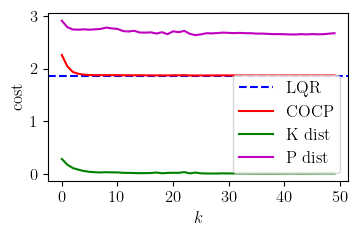

In [10]:
%matplotlib inline

from utils import latexify
import matplotlib
# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt

latexify(fig_width=4)
fig, ax = plt.subplots()
plt.xticks([0, 10, 20, 30, 40, 50])
plt.gca().yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.axhline(loss_lqr, linestyle='--', color='b', label='LQR')

plt.plot(losses, color='r', label='COCP')
plt.plot(dists, color='g', label='K dist')
plt.plot(dist_ps, color='m', label='P dist')

plt.legend()
plt.ylabel("cost")
plt.xlabel("$k$")
plt.subplots_adjust(left=.15, bottom=.2)
plt.savefig("lqr.jpg")
plt.show()

In [26]:
def train(seed_start, P_sqrt):
    losses = []
    opt = torch.optim.SGD([P_sqrt], lr=.5)
    # opt = torch.optim.Adam([P_sqrt], lr=0.001)
    test_loss = None

    dist_ps = []
    dists = []

    for k in range(50):
        with torch.no_grad():
            test_loss = loss(100, 6, P_sqrt.detach(), seed=0).item()
            losses.append(test_loss)

            rhs = -Bt.t() @ P_sqrt.t() @ P_sqrt @ At
            lhs = Rt + Bt.t() @ P_sqrt.t() @ P_sqrt @ Bt
    #         print(A_temp.shape)
    #         print(B_temp.shape)

            K_np = (torch.linalg.solve(
                lhs,
                rhs
            )).detach().numpy()
            dist = np.linalg.norm(K_np - Kt)
            dists.append(dist)

            P = (P_sqrt.t() @ P_sqrt).detach().numpy()
            dist_P = np.linalg.norm(P_lqr - P)
            dist_ps.append(dist_P)

            print("it: %03d, loss: %3.3f, dist: %3.3f, dist_P: %3.3f" % (
                k+1, test_loss - loss_lqr, dist, dist_P))

        opt.zero_grad()
        l = loss(100, 6, P_sqrt, seed=seed_start + k)
    #     print("l", l.item())
        l.backward()
        opt.step()

        # why?
        if k == 25:
            opt = torch.optim.SGD([P_sqrt], lr=.1)
            
    return losses, dist_ps, dists, opt

# now what if i started with a some different initial values for P?
# if they lead to different converged losses, this confirms that \hat{J} is nonconvex
# and that this is doing 'local search'
# we cannot do better than P_lqr, but we can do worse

data = {}
s = 5
for i in np.linspace(-s, s, 2*s+1):
    print(i)
    
    P_sqrt2 = i*torch.eye(n).double(); P_sqrt2.requires_grad_(True);
    losses2, dist_ps2, dists2, opt2 = train(100*i+60, P_sqrt2)

    data[i] = {
        "losses" : losses2,
        "dist_ps" : dist_ps2,
        "dist" : dists2,
        "opt" : opt2
    }

data2 = {}
s = 5
for i in np.linspace(-s, s, 2*s+1):
    print(i)
    
    P_sqrt2 = i*torch.eye(n).double(); P_sqrt2.requires_grad_(True);
    losses2, dist_ps2, dists2, opt2 = train(1, P_sqrt2)

    data2[i] = {
        "losses" : losses2,
        "dist_ps" : dist_ps2,
        "dist" : dists2,
        "opt" : opt2
    }

-5.0
it: 001, loss: 0.173, dist: 0.366, dist_P: 46.457
it: 002, loss: 0.150, dist: 0.352, dist_P: 46.438
it: 003, loss: 0.138, dist: 0.345, dist_P: 46.431
it: 004, loss: 0.127, dist: 0.338, dist_P: 46.439
it: 005, loss: 0.121, dist: 0.335, dist_P: 46.434
it: 006, loss: 0.113, dist: 0.329, dist_P: 46.444
it: 007, loss: 0.108, dist: 0.325, dist_P: 46.452
it: 008, loss: 0.103, dist: 0.322, dist_P: 46.471
it: 009, loss: 0.100, dist: 0.322, dist_P: 46.483
it: 010, loss: 0.094, dist: 0.317, dist_P: 46.509
it: 011, loss: 0.090, dist: 0.314, dist_P: 46.535
it: 012, loss: 0.085, dist: 0.308, dist_P: 46.580
it: 013, loss: 0.082, dist: 0.305, dist_P: 46.608
it: 014, loss: 0.080, dist: 0.303, dist_P: 46.624
it: 015, loss: 0.076, dist: 0.300, dist_P: 46.676
it: 016, loss: 0.073, dist: 0.295, dist_P: 46.709
it: 017, loss: 0.071, dist: 0.292, dist_P: 46.728
it: 018, loss: 0.069, dist: 0.288, dist_P: 46.761
it: 019, loss: 0.068, dist: 0.288, dist_P: 46.778
it: 020, loss: 0.065, dist: 0.283, dist_P: 46

it: 015, loss: 0.007, dist: 0.094, dist_P: 4.655
it: 016, loss: 0.005, dist: 0.084, dist_P: 4.637
it: 017, loss: 0.005, dist: 0.080, dist_P: 4.619
it: 018, loss: 0.004, dist: 0.071, dist_P: 4.622
it: 019, loss: 0.004, dist: 0.077, dist_P: 4.606
it: 020, loss: 0.003, dist: 0.062, dist_P: 4.630
it: 021, loss: 0.007, dist: 0.091, dist_P: 4.607
it: 022, loss: 0.005, dist: 0.075, dist_P: 4.619
it: 023, loss: 0.008, dist: 0.090, dist_P: 4.622
it: 024, loss: 0.001, dist: 0.046, dist_P: 4.623
it: 025, loss: 0.002, dist: 0.046, dist_P: 4.624
it: 026, loss: 0.001, dist: 0.039, dist_P: 4.613
it: 027, loss: 0.002, dist: 0.047, dist_P: 4.602
it: 028, loss: 0.002, dist: 0.045, dist_P: 4.604
it: 029, loss: 0.002, dist: 0.049, dist_P: 4.604
it: 030, loss: 0.003, dist: 0.054, dist_P: 4.602
it: 031, loss: 0.002, dist: 0.048, dist_P: 4.604
it: 032, loss: 0.002, dist: 0.046, dist_P: 4.606
it: 033, loss: 0.002, dist: 0.047, dist_P: 4.606
it: 034, loss: 0.002, dist: 0.043, dist_P: 4.609
it: 035, loss: 0.002

it: 031, loss: 0.002, dist: 0.017, dist_P: 2.675
it: 032, loss: 0.002, dist: 0.017, dist_P: 2.671
it: 033, loss: 0.002, dist: 0.018, dist_P: 2.676
it: 034, loss: 0.002, dist: 0.016, dist_P: 2.669
it: 035, loss: 0.002, dist: 0.016, dist_P: 2.670
it: 036, loss: 0.001, dist: 0.015, dist_P: 2.661
it: 037, loss: 0.001, dist: 0.015, dist_P: 2.662
it: 038, loss: 0.001, dist: 0.015, dist_P: 2.657
it: 039, loss: 0.001, dist: 0.015, dist_P: 2.653
it: 040, loss: 0.001, dist: 0.016, dist_P: 2.652
it: 041, loss: 0.001, dist: 0.016, dist_P: 2.650
it: 042, loss: 0.001, dist: 0.018, dist_P: 2.646
it: 043, loss: 0.001, dist: 0.016, dist_P: 2.645
it: 044, loss: 0.001, dist: 0.015, dist_P: 2.652
it: 045, loss: 0.001, dist: 0.017, dist_P: 2.647
it: 046, loss: 0.001, dist: 0.016, dist_P: 2.653
it: 047, loss: 0.001, dist: 0.017, dist_P: 2.648
it: 048, loss: 0.001, dist: 0.018, dist_P: 2.651
it: 049, loss: 0.001, dist: 0.017, dist_P: 2.661
it: 050, loss: 0.001, dist: 0.017, dist_P: 2.670
2.0
it: 001, loss: 0

it: 047, loss: 0.032, dist: 0.210, dist_P: 28.972
it: 048, loss: 0.032, dist: 0.209, dist_P: 28.973
it: 049, loss: 0.032, dist: 0.210, dist_P: 28.972
it: 050, loss: 0.032, dist: 0.211, dist_P: 28.973
5.0
it: 001, loss: 0.173, dist: 0.366, dist_P: 46.457
it: 002, loss: 0.150, dist: 0.352, dist_P: 46.438
it: 003, loss: 0.138, dist: 0.345, dist_P: 46.431
it: 004, loss: 0.127, dist: 0.338, dist_P: 46.439
it: 005, loss: 0.121, dist: 0.335, dist_P: 46.434
it: 006, loss: 0.113, dist: 0.329, dist_P: 46.444
it: 007, loss: 0.108, dist: 0.325, dist_P: 46.452
it: 008, loss: 0.103, dist: 0.322, dist_P: 46.471
it: 009, loss: 0.100, dist: 0.322, dist_P: 46.483
it: 010, loss: 0.094, dist: 0.317, dist_P: 46.509
it: 011, loss: 0.090, dist: 0.314, dist_P: 46.535
it: 012, loss: 0.085, dist: 0.308, dist_P: 46.580
it: 013, loss: 0.082, dist: 0.305, dist_P: 46.608
it: 014, loss: 0.080, dist: 0.303, dist_P: 46.624
it: 015, loss: 0.076, dist: 0.300, dist_P: 46.676
it: 016, loss: 0.073, dist: 0.295, dist_P: 46.

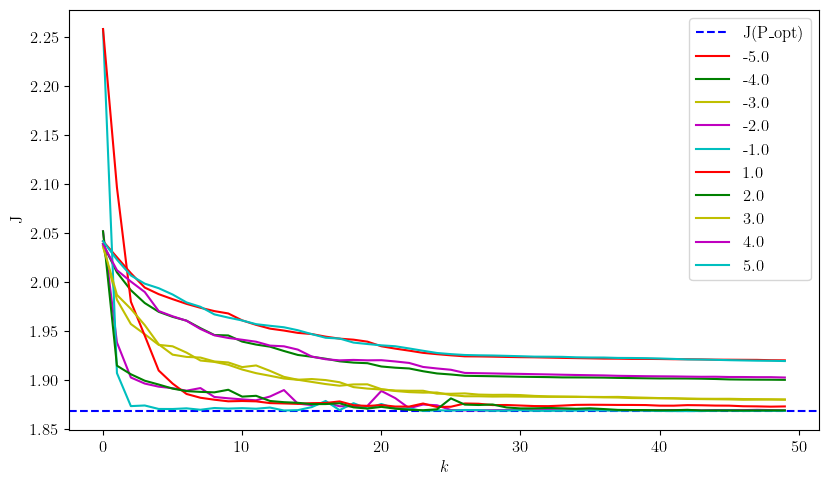

In [25]:
latexify(fig_width=10)
fig, ax = plt.subplots()
plt.xticks([0, 10, 20, 30, 40, 50])
plt.gca().yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.axhline(loss_lqr, linestyle='--', color='b', label='J(P_opt)')

colors = 'rgymck'

all_keys = sorted(data.keys())
for s_i, s in enumerate(all_keys):
    if np.abs(s) < 1e-3:
        continue
    plt.plot(data[s]["losses"], color=colors[s_i % len(colors)], label=s)

plt.legend()
plt.ylabel("J")
plt.xlabel("$k$")
plt.subplots_adjust(left=.15, bottom=.2)
plt.savefig("all_lqr.jpg")
plt.show()

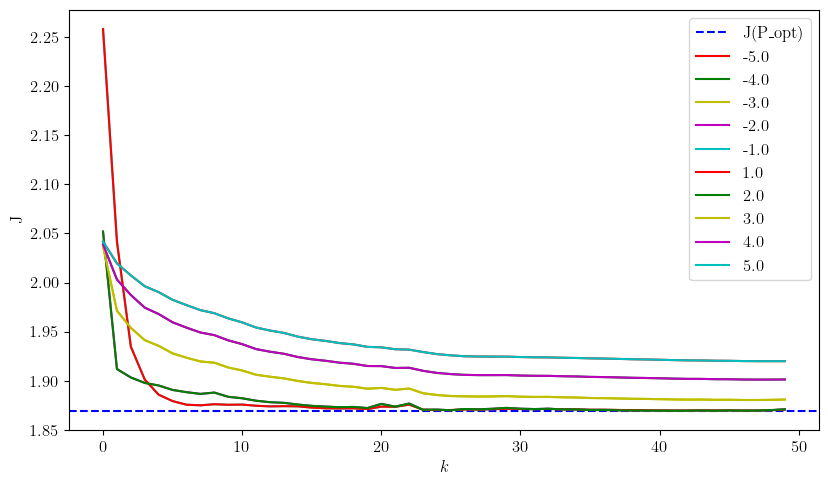

In [27]:
latexify(fig_width=10)
fig, ax = plt.subplots()
plt.xticks([0, 10, 20, 30, 40, 50])
plt.gca().yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
plt.axhline(loss_lqr, linestyle='--', color='b', label='J(P_opt)')

colors = 'rgymck'

all_keys = sorted(data.keys())
for s_i, s in enumerate(all_keys):
    if np.abs(s) < 1e-3:
        continue
    plt.plot(data2[s]["losses"], color=colors[s_i % len(colors)], label=s)

plt.legend()
plt.ylabel("J")
plt.xlabel("$k$")
plt.subplots_adjust(left=.15, bottom=.2)
plt.savefig("all_lqr.jpg")
plt.show()

In [ ]:
# The other question is if we can include R terms in \theta, and how that impacts          